## Clustering Health Facilities 
### Finding most needy health facilities to support

#### Data analysis steps:
    1 Reading data and undrestanding the data
        1.1 reading data
        1.2 inspecting dataframe
        1.3 EDA and Data Cleaning
        1.4 Hopkins statistics
    2 Preparing data for modeling and select number of k
    3 Modeling 
    4 Cluster Profiling
    5 Final Analysis and Printing List of Low Performing Health Facilities

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import getpass
import requests as rq
from io import StringIO
import warnings
warnings.filterwarnings("ignore")
sns.set()


import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


### 1. Reading and understanding the Data
#### 1.1 Reading the Data

In [63]:
dhis_uname= 'admin'
user_pass = 'district'
dhis_url="https://play.im.dhis2.org/stable-2-39-6/api/analytics.csv?dimension=dx%3AUOlfIjgN8X6%3BfbfJHSPpUQD%3BhfdmMSPBgLG%3BLhoRsqtRn4r%3Bk1vnEuKnRYE%3Bo0fOD1HLuv8%3BTBbCcJfZ91x%3BoNyB0VOXIM8%3BHJulLfnIAE3&dimension=ou%3AImspTQPwCqd%3BLEVEL-m9lBJogzE95&dimension=J5jldMd8OHv%3ACXw2yu5fodb%3BuYxK4wmcPqA%3BRXL3lPSK8oG%3BtDZVQ1WtwpA%3BEYbopBOJWsW&tableLayout=true&columns=dx&rows=ou%3BJ5jldMd8OHv&skipRounding=false&completedOnly=false&hideEmptyRows=true&showHierarchy=true&filter=pe%3ALAST_6_MONTHS"
response=rq.get(dhis_url, auth=(dhis_uname,user_pass))
df=pd.DataFrame(pd.read_csv(StringIO(response.text)))
df.head()

,orgunitlevel1,orgunitlevel2,orgunitlevel3,orgunitlevel4,organisationunitid,organisationunitname,organisationunitcode,organisationunitdescription,organisationunitid.1,organisationunitname.1,...,organisationunitdescription.1,Fully Immunized child,ANC 1st visit,ANC 4th or more visits,Postnatal 1st contact (within 1 week),Postnatal 2nd contact (at 6 weeks),HIV: counseling,Clinical Malnutrition new,Clinical Malnutrition referrals,Clinical Malnutrition follow-up
0,Sierra Leone,Western Area,Rural Western Area,Afro Arab Clinic,cDw53Ej8rju,Afro Arab Clinic,OU_278371,NaN,RXL3lPSK8oG,Clinic,...,NaN,NaN,NaN,NaN,NaN,NaN,991.0,490.0,7.0,10.0
1,Sierra Leone,Bo,Kakua,Agape CHP,GvFqTavdpGE,Agape CHP,OU_678892,NaN,RXL3lPSK8oG,Clinic,...,NaN,NaN,36.0,53.0,6.0,4.0,NaN,17.0,NaN,8.0
2,Sierra Leone,Koinadugu,Nieni,Alkalia CHP,dWOAzMcK2Wt,Alkalia CHP,OU_226272,NaN,EYbopBOJWsW,MCHP,...,NaN,NaN,116.0,83.0,61.0,32.0,NaN,51.0,NaN,30.0
3,Sierra Leone,Western Area,Freetown,Approved School CHP,eoYV2p74eVz,Approved School CHP,OU_278314,NaN,uYxK4wmcPqA,CHP,...,NaN,NaN,287.0,22.0,476.0,384.0,3155.0,292.0,NaN,8.0
4,Sierra Leone,Kenema,Wandor,Baama CHC,r5WWF9WDzoa,Baama CHC,OU_222681,NaN,CXw2yu5fodb,CHC,...,NaN,113.0,94.0,NaN,66.0,14.0,1337.0,NaN,NaN,NaN


In [64]:
df.columns

Index(['orgunitlevel1', 'orgunitlevel2', 'orgunitlevel3', 'orgunitlevel4',
       'organisationunitid', 'organisationunitname', 'organisationunitcode',
       'organisationunitdescription', 'organisationunitid.1',
       'organisationunitname.1', 'organisationunitcode.1',
       'organisationunitdescription.1', 'Fully Immunized child',
       'ANC 1st visit', 'ANC 4th or more visits',
       'Postnatal 1st contact (within 1 week)',
       'Postnatal 2nd contact (at 6 weeks)', 'HIV: counseling',
       'Clinical Malnutrition new', 'Clinical Malnutrition referrals',
       'Clinical Malnutrition follow-up'],
      dtype='object')

In [65]:
df.drop(columns=['orgunitlevel1','organisationunitid','organisationunitname','organisationunitdescription',
                 'organisationunitid.1', 'organisationunitcode.1',
                 'organisationunitdescription.1'],axis=1,inplace=True)

df.columns=['Province', 'District', 'FacilityName','FacilityId','FacilityType', 'Fully Immunized child', 'ANC 1st visit',
           'ANC 4th or more visits', 'Postnatal 1st contact (within 1 week)','Postnatal 2nd contact (at 6 weeks)', 
            'HIV: counseling','Clinical Malnutrition new', 'Clinical Malnutrition referrals','Clinical Malnutrition follow-up']
df.head()

,Province,District,FacilityName,FacilityId,FacilityType,Fully Immunized child,ANC 1st visit,ANC 4th or more visits,Postnatal 1st contact (within 1 week),Postnatal 2nd contact (at 6 weeks),HIV: counseling,Clinical Malnutrition new,Clinical Malnutrition referrals,Clinical Malnutrition follow-up
0,Western Area,Rural Western Area,Afro Arab Clinic,OU_278371,Clinic,NaN,NaN,NaN,NaN,NaN,991.0,490.0,7.0,10.0
1,Bo,Kakua,Agape CHP,OU_678892,Clinic,NaN,36.0,53.0,6.0,4.0,NaN,17.0,NaN,8.0
2,Koinadugu,Nieni,Alkalia CHP,OU_226272,MCHP,NaN,116.0,83.0,61.0,32.0,NaN,51.0,NaN,30.0
3,Western Area,Freetown,Approved School CHP,OU_278314,CHP,NaN,287.0,22.0,476.0,384.0,3155.0,292.0,NaN,8.0
4,Kenema,Wandor,Baama CHC,OU_222681,CHC,113.0,94.0,NaN,66.0,14.0,1337.0,NaN,NaN,NaN


#### 1.2 Inspecting the dataframe

In [66]:
df.shape

(1043, 14)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Province                               1043 non-null   object 
 1   District                               1043 non-null   object 
 2   FacilityName                           1043 non-null   object 
 3   FacilityId                             1043 non-null   object 
 4   FacilityType                           1043 non-null   object 
 5   Fully Immunized child                  227 non-null    float64
 6   ANC 1st visit                          1031 non-null   float64
 7   ANC 4th or more visits                 917 non-null    float64
 8   Postnatal 1st contact (within 1 week)  1020 non-null   float64
 9   Postnatal 2nd contact (at 6 weeks)     947 non-null    float64
 10  HIV: counseling                        597 non-null    float64
 11  Clin

### 1.3 Exploratory Data Analysis and Data Cleaning

In [68]:
# Inspecting for missing values
round((df.isnull().sum()/len(df.index))*100,2)

Province                                  0.00
District                                  0.00
FacilityName                              0.00
FacilityId                                0.00
FacilityType                              0.00
Fully Immunized child                    78.24
ANC 1st visit                             1.15
ANC 4th or more visits                   12.08
Postnatal 1st contact (within 1 week)     2.21
Postnatal 2nd contact (at 6 weeks)        9.20
HIV: counseling                          42.76
Clinical Malnutrition new                10.16
Clinical Malnutrition referrals          70.37
Clinical Malnutrition follow-up          50.43
dtype: float64

In [34]:
# Missing values could be due service unavailability in some types of health facilities 
# In this example we assume that the service was availble but didn't have clients so I replace them with zero 
df = df.fillna(0)
round((df.isnull().sum()/len(df.index))*100,2)

Province                                 0.0
District                                 0.0
FacilityName                             0.0
FacilityId                               0.0
FacilityType                             0.0
Fully Immunized child                    0.0
ANC 1st visit                            0.0
ANC 4th or more visits                   0.0
Postnatal 1st contact (within 1 week)    0.0
Postnatal 2nd contact (at 6 weeks)       0.0
HIV: counseling                          0.0
Clinical Malnutrition new                0.0
Clinical Malnutrition referrals          0.0
Clinical Malnutrition follow-up          0.0
dtype: float64

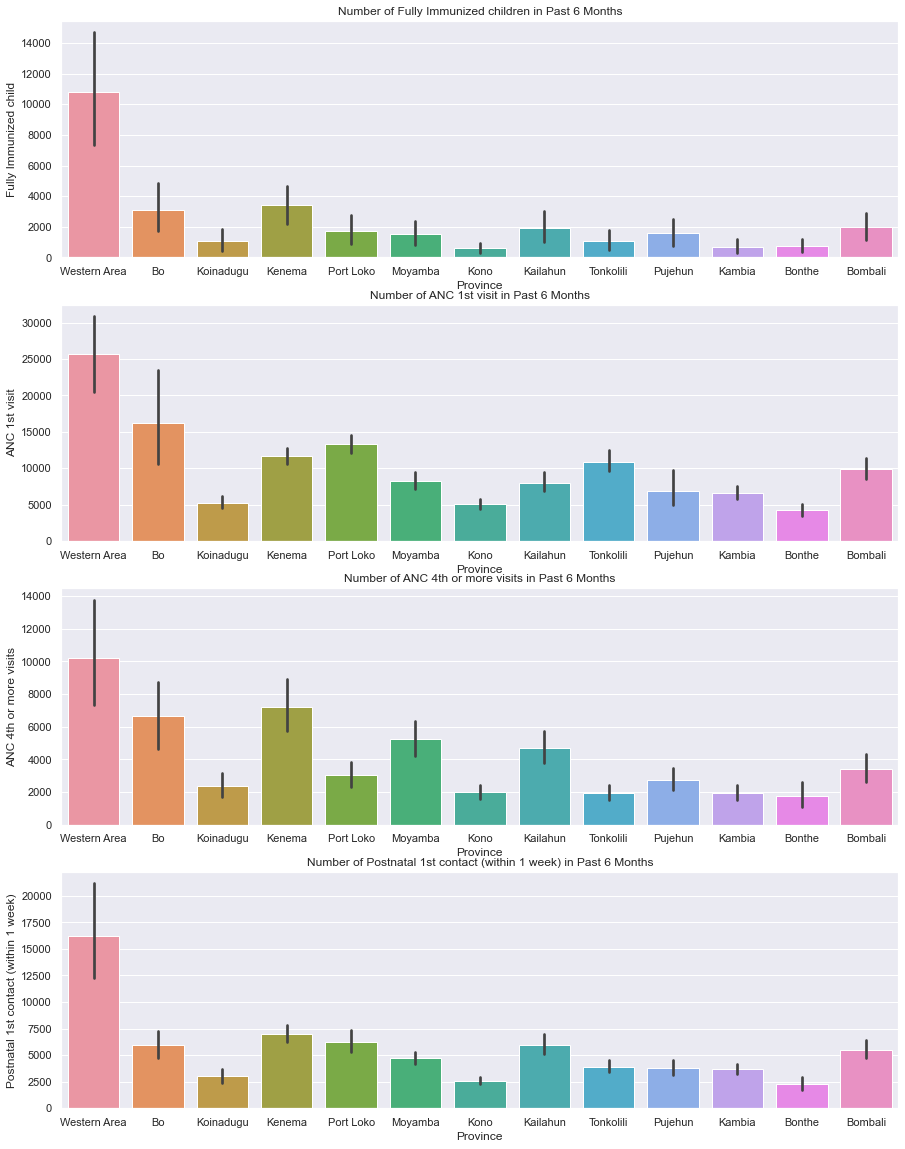

In [35]:
plt.figure(figsize=(15,20))
plt.subplot(4,1,1)
sns.barplot(x = 'Province',y='Fully Immunized child',estimator=sum,data=df)
plt.title('Number of Fully Immunized children in Past 6 Months')

plt.subplot(4,1,2)
sns.barplot(x = 'Province',y='ANC 1st visit',estimator=sum,data=df)
plt.title('Number of ANC 1st visit in Past 6 Months')

plt.subplot(4,1,3)
sns.barplot(x = 'Province',y='ANC 4th or more visits',estimator=sum,data=df)
plt.title('Number of ANC 4th or more visits in Past 6 Months')

plt.subplot(4,1,4)
sns.barplot(x = 'Province',y='Postnatal 1st contact (within 1 week)',estimator=sum,data=df)
plt.title('Number of Postnatal 1st contact (within 1 week) in Past 6 Months')
plt.show()

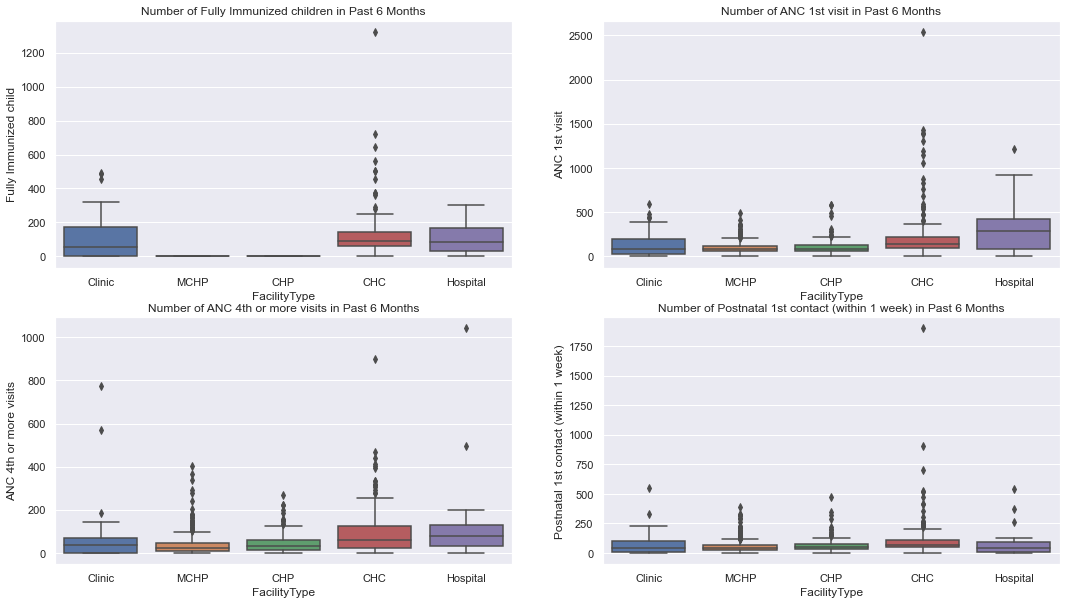

In [36]:
plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
sns.boxplot(x = 'FacilityType',y='Fully Immunized child',data=df)
plt.title('Number of Fully Immunized children in Past 6 Months')

plt.subplot(2,2,2)
sns.boxplot(x = 'FacilityType',y='ANC 1st visit',data=df)
plt.title('Number of ANC 1st visit in Past 6 Months')

plt.subplot(2,2,3)
sns.boxplot(x = 'FacilityType',y='ANC 4th or more visits',data=df)
plt.title('Number of ANC 4th or more visits in Past 6 Months')

plt.subplot(2,2,4)
sns.boxplot(x = 'FacilityType',y='Postnatal 1st contact (within 1 week)',data=df)
plt.title('Number of Postnatal 1st contact (within 1 week) in Past 6 Months')

plt.show()

#### Outliers are available which have to be handled for just for this example we ignore them

<Figure size 1440x1080 with 0 Axes>

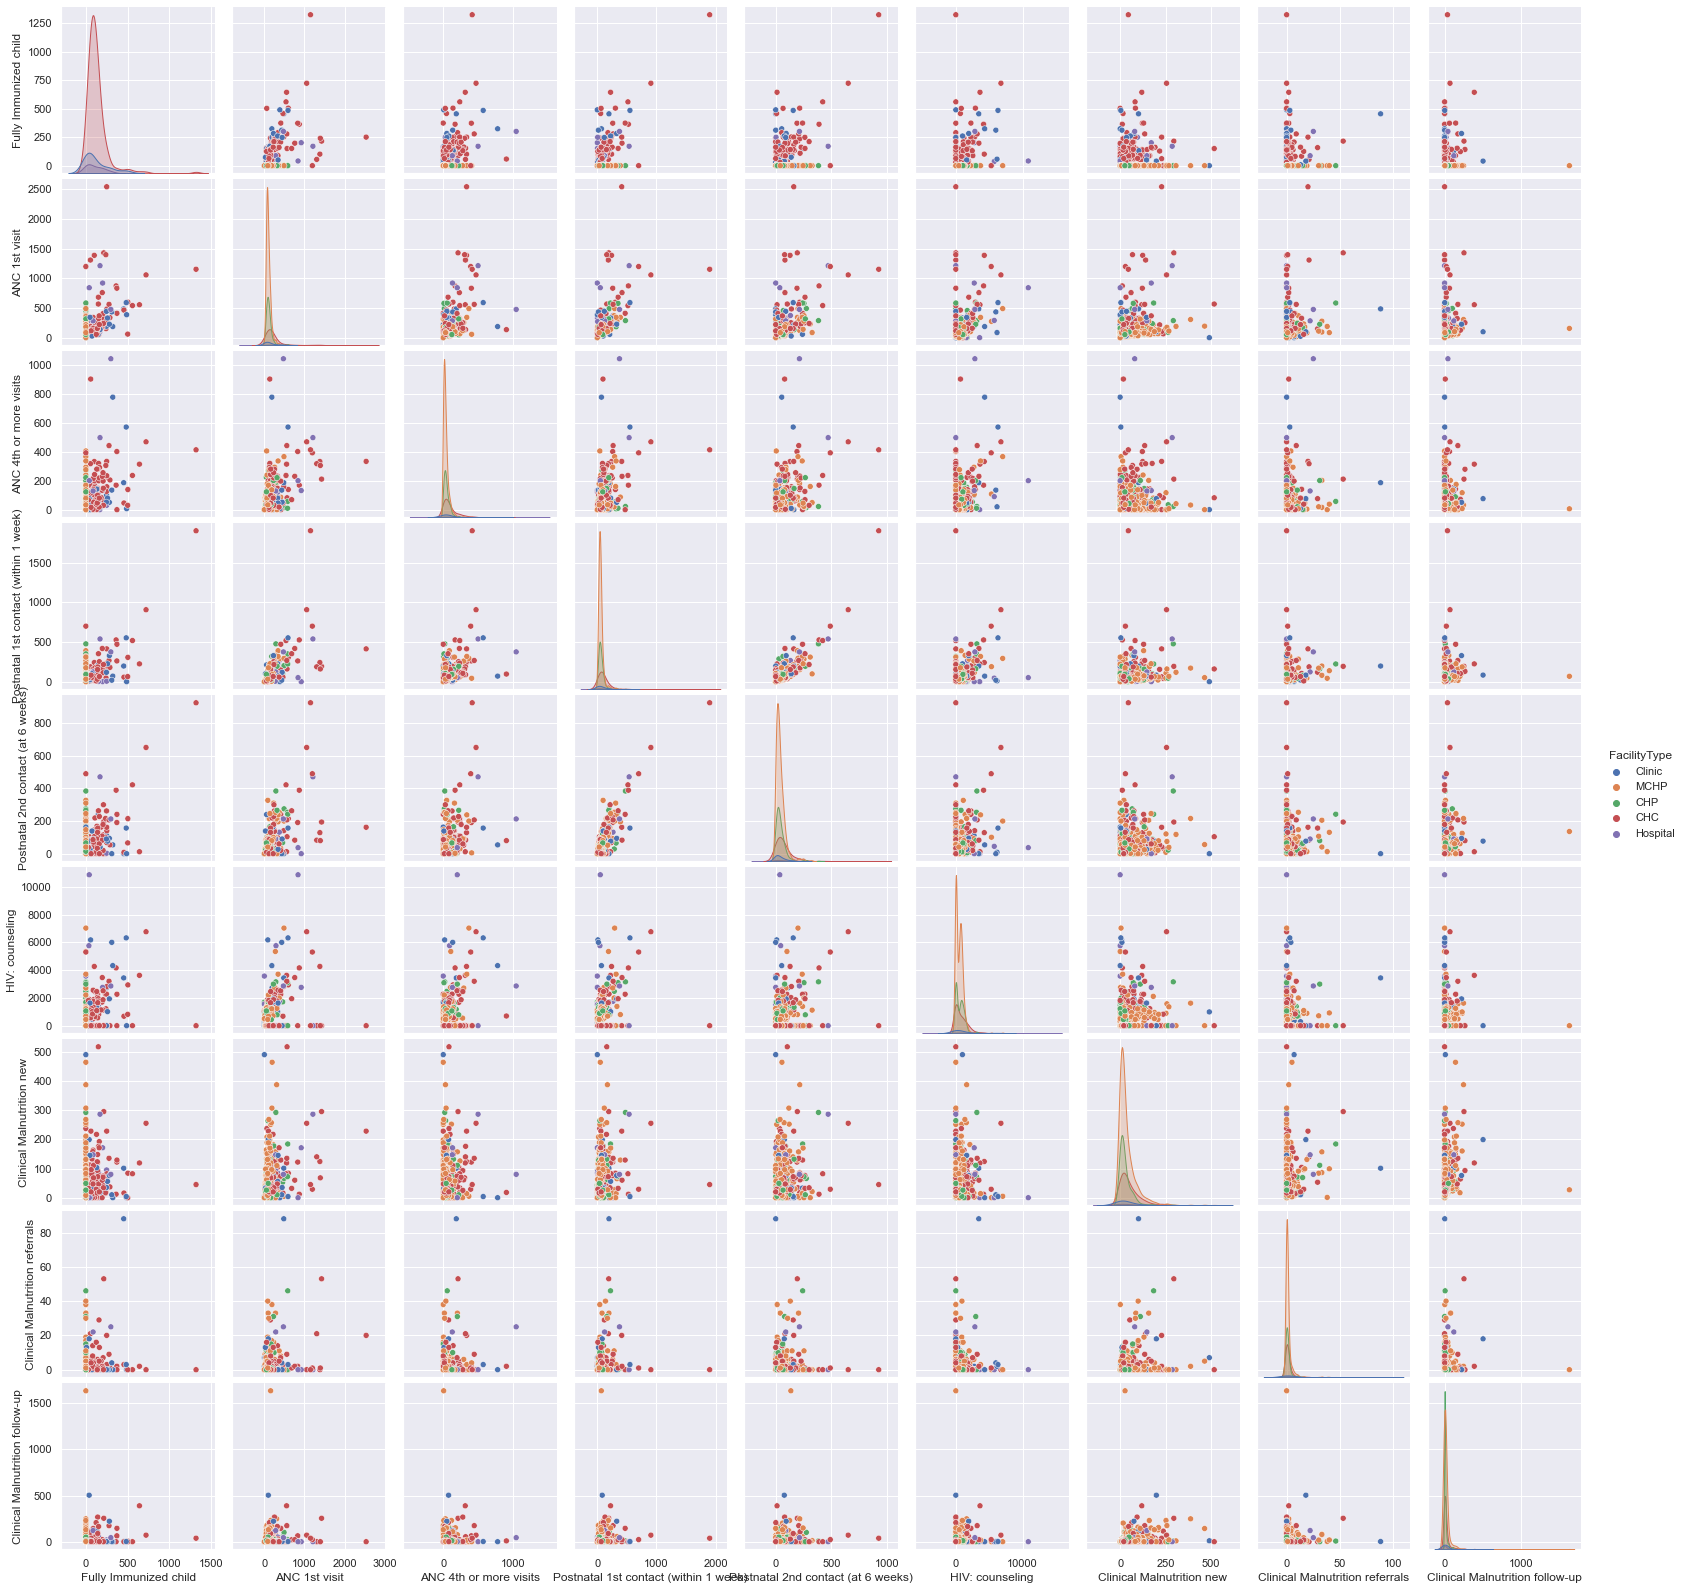

In [37]:
# bi-variate analysis:
# looking for coorelations and  outliers by ploting bi-variate analysis on a pairplot
plt.figure(figsize=(20,15))
sns.pairplot(df,hue='FacilityType')
plt.show()

#### There are outliers in the above bi-variate analysis but for this example we ignore them

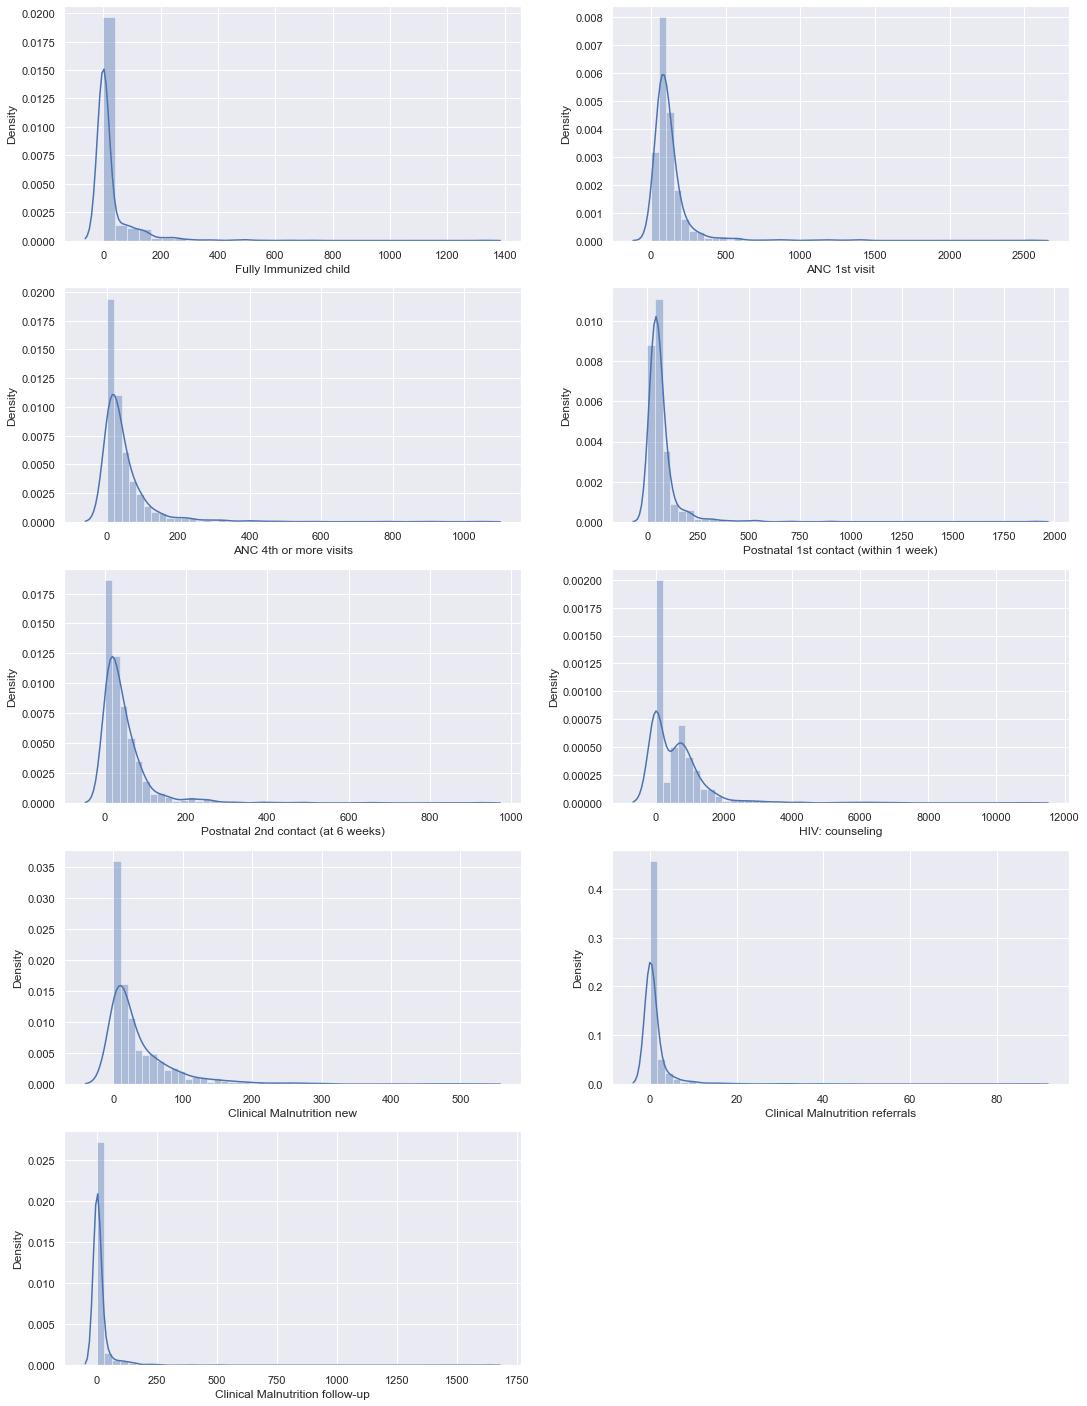

In [38]:
# Looking distribution of the features
col = ['Fully Immunized child', 'ANC 1st visit', 'ANC 4th or more visits',
       'Postnatal 1st contact (within 1 week)',
       'Postnatal 2nd contact (at 6 weeks)', 'HIV: counseling',
       'Clinical Malnutrition new', 'Clinical Malnutrition referrals',
       'Clinical Malnutrition follow-up']
plt.figure(figsize=(18,25))
for i in enumerate(col): 
    ax = plt.subplot(5, 2, i[0]+1)
    sns.distplot(df[i[1]])

### Hopkins Statistics
    - To check if the dataset has tendency to clustering
    - If the score is between 0.01 - 0.3, the data is reguraly spaced
    - If the score is around the 0.50, the is data random
    - if the score is above 0.70, the data has high tendency to clutering

In [39]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [40]:
hopkins(df[col])

0.9571320229362216

## K-Means Clustering
### 2. Preparing data for modeling and selecting number of k
#### Select number of k by below methods
1. Elbow Curve Method
2. Silhouette method

In [41]:
# standardizing the columns'
columns = df[col].copy()
scaler = StandardScaler()

col_scaled = scaler.fit_transform(columns)
# converting np array to dataframe
col_scaled = pd.DataFrame(col_scaled)
col_scaled.columns = col
col_scaled.head()

,Fully Immunized child,ANC 1st visit,ANC 4th or more visits,Postnatal 1st contact (within 1 week),Postnatal 2nd contact (at 6 weeks),HIV: counseling,Clinical Malnutrition new,Clinical Malnutrition referrals,Clinical Malnutrition follow-up
0,-0.346116,-0.789092,-0.634356,-0.738388,-0.729957,0.434047,8.303915,1.074052,-0.086818
1,-0.346116,-0.564770,0.026230,-0.673249,-0.667844,-0.692060,-0.381030,-0.288292,-0.118501
2,-0.346116,-0.066278,0.400147,-0.076141,-0.233056,-0.692060,0.243258,-0.288292,0.230015
3,-0.346116,0.999248,-0.360151,4.429306,5.232850,2.893072,4.668357,-0.288292,-0.118501
4,0.998585,-0.203364,-0.634356,-0.021859,-0.512563,0.827218,-0.693174,-0.288292,-0.245234


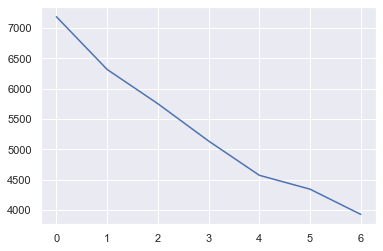

In [42]:
ssd = []
range_of_k = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_of_k:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(col_scaled)
    
    ssd.append(kmeans.inertia_)
    
plt.plot(ssd)
plt.show()

In [43]:
# silhouette method
range_of_k = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_of_k:
    
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(col_scaled)
    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(col_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.7579285138256187
For n_clusters=3, the silhouette score is 0.49384680317950375
For n_clusters=4, the silhouette score is 0.44888207434312805
For n_clusters=5, the silhouette score is 0.45411513118242475
For n_clusters=6, the silhouette score is 0.4836525722541308
For n_clusters=7, the silhouette score is 0.42920505567610023
For n_clusters=8, the silhouette score is 0.2233249093074931


##### From the elbow method and silhouette score it can be indicated that suitable number of cluster is 4

### 3. Modeling

In [44]:
# modeling with k = 4
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(col_scaled)

KMeans(max_iter=50, n_clusters=4)

In [45]:
df['Cluster_id'] = kmeans.labels_
df.head()

,Province,District,FacilityName,FacilityId,FacilityType,Fully Immunized child,ANC 1st visit,ANC 4th or more visits,Postnatal 1st contact (within 1 week),Postnatal 2nd contact (at 6 weeks),HIV: counseling,Clinical Malnutrition new,Clinical Malnutrition referrals,Clinical Malnutrition follow-up,Cluster_id
0,Western Area,Rural Western Area,Afro Arab Clinic,OU_278371,Clinic,0.0,0.0,0.0,0.0,0.0,991.0,490.0,7.0,10.0,3
1,Bo,Kakua,Agape CHP,OU_678892,Clinic,0.0,36.0,53.0,6.0,4.0,0.0,17.0,0.0,8.0,0
2,Koinadugu,Nieni,Alkalia CHP,OU_226272,MCHP,0.0,116.0,83.0,61.0,32.0,0.0,51.0,0.0,30.0,0
3,Western Area,Freetown,Approved School CHP,OU_278314,CHP,0.0,287.0,22.0,476.0,384.0,3155.0,292.0,0.0,8.0,3
4,Kenema,Wandor,Baama CHC,OU_222681,CHC,113.0,94.0,0.0,66.0,14.0,1337.0,0.0,0.0,0.0,0


### 4. Cluster Profiling

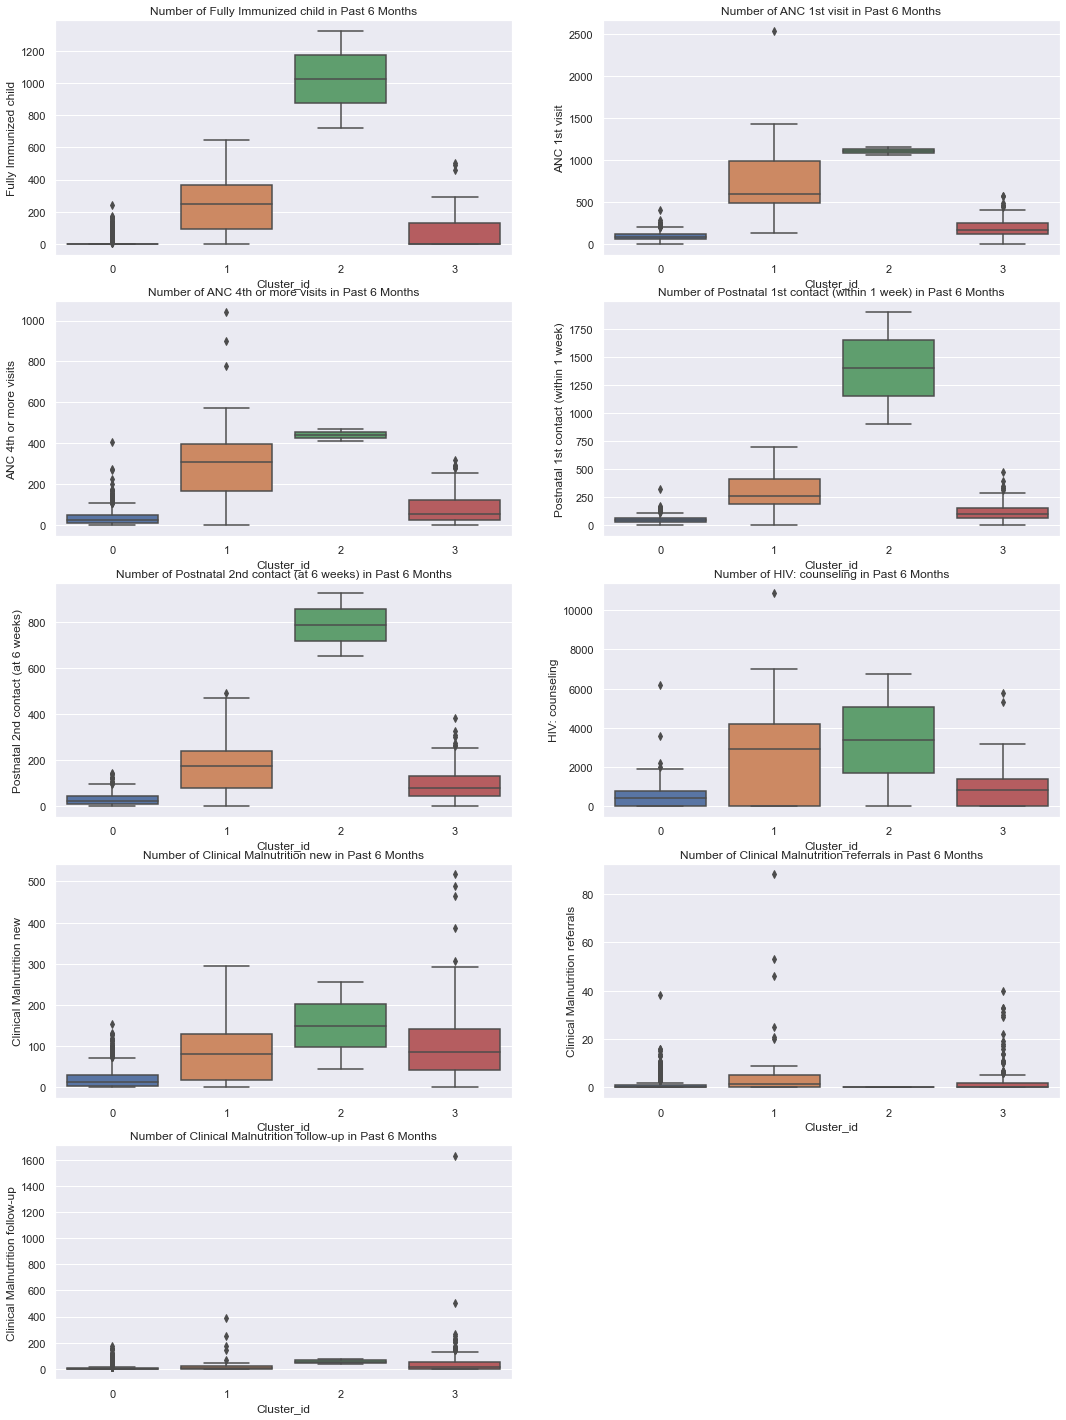

In [49]:
plt.figure(figsize=(18,25))
for i in enumerate(col):
    plt.subplot(5,2,i[0]+1)
    sns.boxplot(x = 'Cluster_id',y=i[1],data=df)
    plt.title('Number of ' + i[1] + ' in Past 6 Months')
    

##### From the above box plots it can be infered that the most low performing cluster of health facilities is cluster = 0

In [50]:
col

['Fully Immunized child',
 'ANC 1st visit',
 'ANC 4th or more visits',
 'Postnatal 1st contact (within 1 week)',
 'Postnatal 2nd contact (at 6 weeks)',
 'HIV: counseling',
 'Clinical Malnutrition new',
 'Clinical Malnutrition referrals',
 'Clinical Malnutrition follow-up']

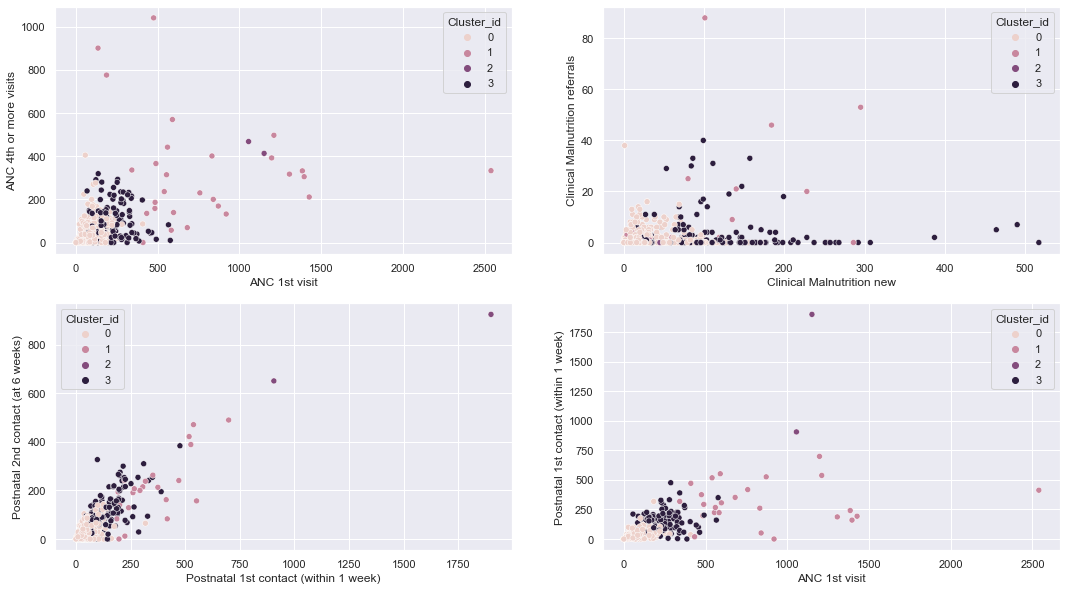

In [51]:
plt.figure(figsize=(18,10))
plt.subplot(2,2,1)
sns.scatterplot(data = df, x='ANC 1st visit',y='ANC 4th or more visits',hue='Cluster_id')
plt.subplot(2,2,2)
sns.scatterplot(data=df,x='Clinical Malnutrition new', y='Clinical Malnutrition referrals',hue='Cluster_id')

plt.subplot(2,2,3)
sns.scatterplot(data=df,x='Postnatal 1st contact (within 1 week)', y='Postnatal 2nd contact (at 6 weeks)',hue='Cluster_id')

plt.subplot(2,2,4)
sns.scatterplot(data=df,x='ANC 1st visit', y='Postnatal 1st contact (within 1 week)',hue='Cluster_id')
plt.show()

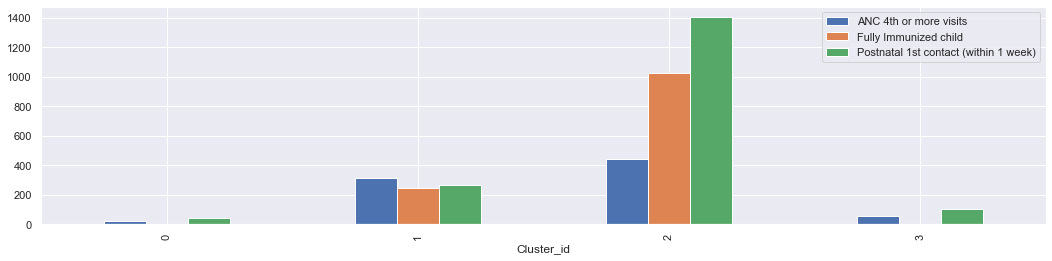

In [54]:
df.groupby('Cluster_id')[['ANC 4th or more visits','Fully Immunized child',
                          'Postnatal 1st contact (within 1 week)']].median().plot(kind='bar',figsize=(18,4))
plt.show()

##### From the scatter and bar plots also it can be infered that the cluster with the lowest performance is cluster=0

###   5. Final Analysis and Printing List of Low Performing Health Facilities

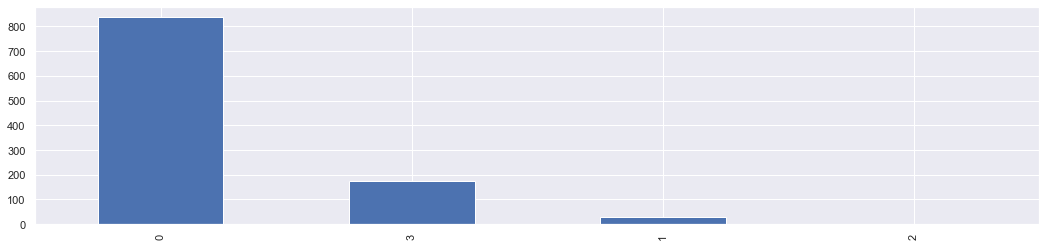

In [53]:
# Count number of health facilities in each cluster
plt.figure(figsize=(18,4))
df.Cluster_id.value_counts().plot(kind='bar')
plt.show()

In [55]:
df.columns

Index(['Province', 'District', 'FacilityName', 'FacilityId', 'FacilityType',
       'Fully Immunized child', 'ANC 1st visit', 'ANC 4th or more visits',
       'Postnatal 1st contact (within 1 week)',
       'Postnatal 2nd contact (at 6 weeks)', 'HIV: counseling',
       'Clinical Malnutrition new', 'Clinical Malnutrition referrals',
       'Clinical Malnutrition follow-up', 'Cluster_id'],
      dtype='object')

<AxesSubplot:xlabel='FacilityType'>

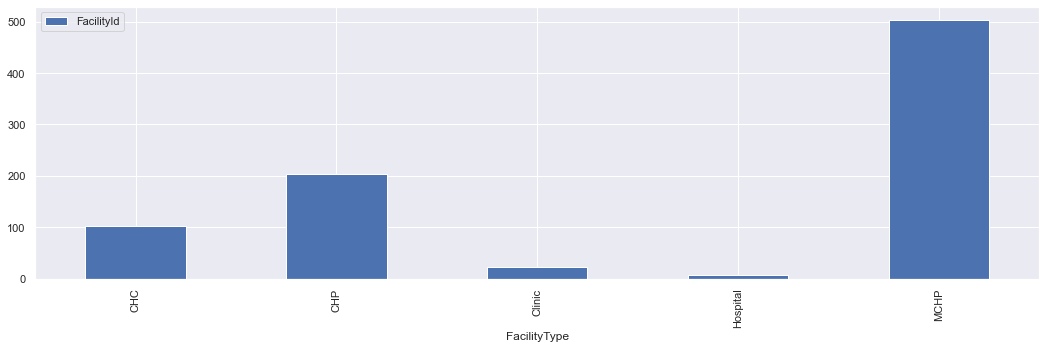

In [59]:
# Counting number of health facility in cluster=0 by types of health facilities
df.loc[df.Cluster_id==0].pivot_table(index='FacilityType',values='FacilityId',
               aggfunc=pd.Series.nunique).plot(kind='bar',figsize=(18,5))

In [60]:
# List of low performing health facilities
df.loc[df.Cluster_id==0].head()

,Province,District,FacilityName,FacilityId,FacilityType,Fully Immunized child,ANC 1st visit,ANC 4th or more visits,Postnatal 1st contact (within 1 week),Postnatal 2nd contact (at 6 weeks),HIV: counseling,Clinical Malnutrition new,Clinical Malnutrition referrals,Clinical Malnutrition follow-up,Cluster_id
1,Bo,Kakua,Agape CHP,OU_678892,Clinic,0.0,36.0,53.0,6.0,4.0,0.0,17.0,0.0,8.0,0
2,Koinadugu,Nieni,Alkalia CHP,OU_226272,MCHP,0.0,116.0,83.0,61.0,32.0,0.0,51.0,0.0,30.0,0
4,Kenema,Wandor,Baama CHC,OU_222681,CHC,113.0,94.0,0.0,66.0,14.0,1337.0,0.0,0.0,0.0,0
5,Port Loko,Lokomasama,Babara CHC,OU_254991,CHC,76.0,97.0,59.0,71.0,95.0,0.0,3.0,1.0,1.0,0
6,Koinadugu,Diang,Badala MCHP,OU_758905,MCHP,0.0,14.0,6.0,17.0,0.0,0.0,0.0,0.0,0.0,0


## Note: Selecting the right indicators is key. Selected indicators in this analysis is just an example and because of data availability in the https://play.dhis2.org/2.39.6